# Baseline Model
This notebook is meant to apply the most basic data preprocessing techniques to examine if data fusion can help increase the model performance on healthy/impairedCog/AD-Dementia prediction task. The preprocessing steps includes mean/mode imputation, PCA feature dimension reduction, and logistic regression. Notice that in order to "fuse" the other data sources (mri and csf), we conducted an inner join. For example, to check the effects of MRI on UDS data source, we found people with both UDS and MRI records and fit logistic regressions on UDS and UDS+MRI separately. Since few people were recorded in all three data sources, fusing altogether is challenging. 

Future direction:
- Variable Missing Imputation: KNN, RF
- Dimension Reduction: PCA, Group Lasso, AutoEncoder
- Counterfactual data generation: VAE (other generating model maybe)
- Prediction: Group Lasso

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from importlib import reload
import seaborn as sns
import os, sys
from sklearn.preprocessing import LabelEncoder

In [2]:
target_encoder = LabelEncoder()

def load_data(impute_method = 'Mean-Mode', target = 'NACCAD3'):
    uds = pd.read_csv("../data/data_imputed/{}/uds.csv".format(impute_method))
    uds['datetime'] = pd.to_datetime(uds['datetime'])
    uds = uds.dropna(subset=[target, 'EDUC'])
    print("UDS Shape:  ", uds.shape)
    print("Target Distribution: {}\n".format(Counter(uds[target])))
    uds[target] = target_encoder.fit_transform(uds[target])
    mri = pd.read_csv("../data/data_imputed/{}/mri.csv".format(impute_method))
    mri['datetime'] = pd.to_datetime(mri['datetime'])
    
    csf = pd.read_csv("../data/data_imputed/{}/csf.csv".format(impute_method))
    return uds, mri, csf

uds_dict = pd.read_csv("../data/data_dictionary/uds_feature_dictionary_cleaned.csv")
mri_dict = pd.read_csv("../data/data_dictionary/mri_feature_dictionary_cleaned.csv") 

uds_drop_columns = ['NACCID', 'NACCADC', 'NACCVNUM', 'datetime', 'SEX', 'NACCAGE','EDUC', 
                    'NACCUDSD', 'NACCALZP', 'NACCAD3', 'NACCAD5']
mri_drop_columns = ['NACCID', 'NACCVNUM', 'datetime', 'datetime_UDS', 'timediff', 'within-a-year']
csf_drop_columns = ['NACCID', 'CSFABMD', 'CSFTTMD', 'CSFPTMD']

In [3]:
uds, mri, csf = load_data(impute_method = 'Mean-Mode', target = 'NACCAD3')
print(uds.shape, mri.shape, csf.shape)

UDS Shape:   (34025, 89)
Target Distribution: Counter({'Healthy': 17673, 'Dementia-AD': 11882, 'MCI-AD': 4470})

(34025, 89) (2873, 161) (2180, 7)


# PCA feature dimension reduction

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
pca = None

def pca_transform(df, var_dict, n_component, pca_thres = 0.8):
    global pca
    pca = PCA(n_components=n_component)
    to_ret = pd.DataFrame()
    for cat in var_dict['Category'].unique():
        if cat != 'DEMO':
            var_names = var_dict[var_dict['Category'] == cat]['VariableName'].values
            var_names = set(var_names).intersection(set(df.columns))
            if len(var_names) > n_component:
                pca_transformed = pca.fit_transform(scaler.fit_transform(df.loc[:,var_names]))
                num_selected_1 = np.sum(pca.explained_variance_ratio_ > pca_thres)
                num_selected_2 = np.argmax(-np.diff(pca.explained_variance_ratio_, n=1) > 0.1) + 1
                num_selected = max(num_selected_1, num_selected_2)
                temp = pd.DataFrame(pca_transformed[:,:num_selected])
                temp.columns = ["{}_{}".format(cat, i+1) for i in range(num_selected)]
                print(cat, pca.explained_variance_ratio_, num_selected)
                to_ret = pd.concat([to_ret, temp], axis=1)
    return to_ret

def uds_pca_transform(uds, target, heatmap = False):
    # PCA UDS  UDS is unique for each patient at baseline
    assert(len(Counter(uds.groupby('NACCID')['datetime'].count().values)))
    uds_pca = pca_transform(uds.drop(uds_drop_columns, axis=1), uds_dict, 5, pca_thres=0.2)
    uds_pca = pd.concat([uds[['NACCID', 'SEX', 'NACCAGE', 'EDUC', 'NACCAPOE', target]].reset_index(drop=True), uds_pca], axis=1)
    if heatmap:
        plt.figure(figsize = (12,8))
        sns.heatmap(uds_pca.corr(), annot=True, fmt='.2f', cmap='RdYlGn')
        plt.show()
    return uds_pca

def mri_pca_transform(mri, uds_pca, heatmap=False):
    assert(len(Counter(mri.groupby('NACCID')['datetime'].count().values)))
    mri_pca = pca_transform(mri.drop(mri_drop_columns, axis=1), mri_dict, 5, pca_thres=0.1)
    mri_pca['NACCID'] = mri.reset_index()['NACCID']
    uds_mri_merged = uds_pca.merge(mri_pca, on='NACCID', how='inner')
    if heatmap:
        plt.figure(figsize = (15, 10))
        sns.heatmap(uds_mri_merged.corr(), annot=True, fmt='.2f', cmap='RdYlGn')
        plt.show()
    return mri_pca, uds_mri_merged

def csf_pca_transform(csf, uds_mri_merged, heatmap=False):
    csf_pca = csf[['NACCID', 'CSFABETA', 'CSFTTAU', 'CSFPTAU']]
    uds_mri_csf_merged = uds_mri_merged.merge(csf_pca, on='NACCID', how='inner')
    if heatmap:
        plt.figure(figsize = (15, 10))
        sns.heatmap(uds_mri_csf_merged.corr(), annot=True, fmt='.2f', cmap='RdYlGn')
    return csf_pca, uds_mri_csf_merged

CDF [0.77679859 0.11136653 0.03487712 0.0303462  0.01334933] 1
GDS [0.31824549 0.07336373 0.06967335 0.05953553 0.05577813] 1
FAS [0.76628492 0.05771446 0.03790491 0.03111185 0.02731422] 1
NPI [0.30070279 0.07317591 0.07258482 0.06271281 0.0600106 ] 1
NEURO [0.34080635 0.12712819 0.08934641 0.07406121 0.04750313] 1


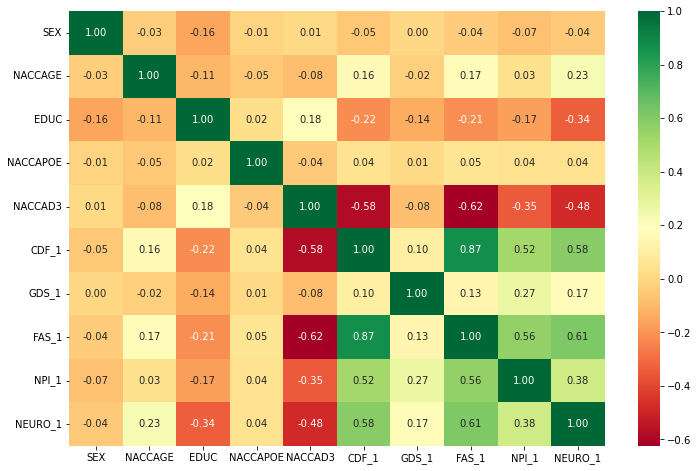

In [5]:
uds_pca = uds_pca_transform(uds, "NACCAD3", True)

Regional gray matter volumes [0.56327925 0.17272831 0.06163145 0.04907454 0.0346227 ] 2
Regional cortical thicknesses [0.44952865 0.05045401 0.03774226 0.03147717 0.0240021 ] 1
PET scan data [0.37569421 0.12838299 0.07782488 0.0606391  0.02956346] 2


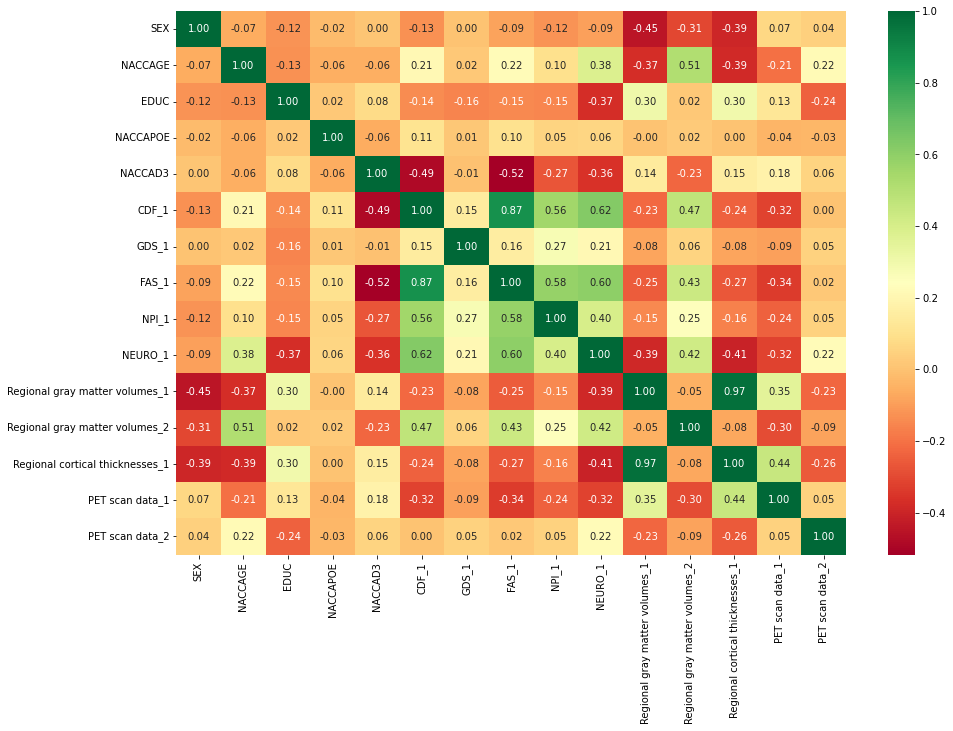

In [6]:
mri_pca, uds_mri_merged = mri_pca_transform(mri, uds_pca, True)

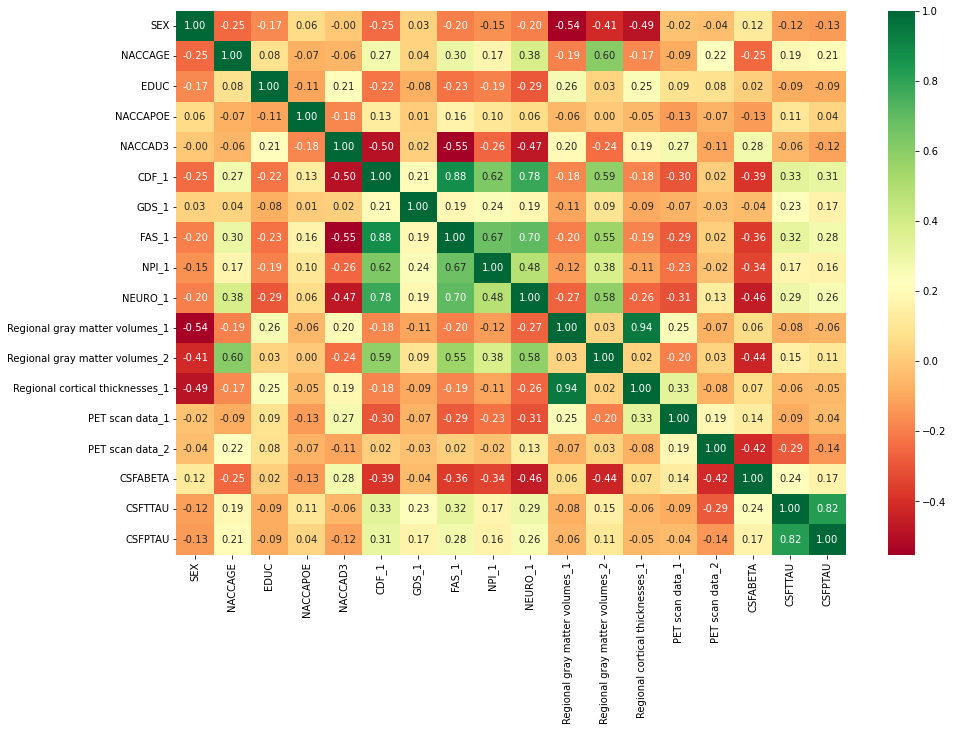

In [7]:
csf_pca, uds_mri_csf_merged = csf_pca_transform(csf, uds_mri_merged, True)

In [8]:
# pca = PCA(n_components=2)
# csf_pca = pca.fit_transform(csf.drop(csf_drop_columns, axis=1))
# print(pca.explained_variance_ratio_)

# csf_pca = pd.DataFrame(csf_pca[:,:2])
# csf_pca.columns = ['CSF_{}'.format(i) for i in range(csf_pca.shape[1])]
# csf_pca['NACCID'] = csf.reset_index()['NACCID']
# uds_mri_cfs_merged = uds_mri_merged.merge(csf_pca, on='NACCID', how='inner')
# print(uds_mri_cfs_merged.shape)

# plt.figure(figsize = (15, 10))
# sns.heatmap(uds_mri_cfs_merged.corr(), annot=True, fmt='.2f', cmap='RdYlGn')

# Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

def print_summary(clf, Xtr, ytr, Xte, yte, confusion_metrix = False):
    if confusion_metrix:
        print(metrics.confusion_matrix(ytr, clf.predict(Xtr)))
        print(metrics.confusion_matrix(yte, clf.predict(Xte)))
    acctr = metrics.accuracy_score(ytr, clf.predict(Xtr))
    auctr = metrics.roc_auc_score(ytr, clf.predict_proba(Xtr), average='macro', multi_class='ovo')
    f1tr_macro = metrics.f1_score(ytr, clf.predict(Xtr), average='macro')
    f1tr_micro = metrics.f1_score(ytr, clf.predict(Xtr), average='micro')
    
    accte = metrics.accuracy_score(yte, clf.predict(Xte))
    aucte = metrics.roc_auc_score(yte, clf.predict_proba(Xte), average='macro', multi_class='ovo')
    f1te_macro = metrics.f1_score(yte, clf.predict(Xte), average='macro')
    f1te_micro = metrics.f1_score(yte, clf.predict(Xte), average='micro')
 
    metrics_df = pd.DataFrame.from_dict({"Train": {"Acc": acctr, "AUC": auctr, "F1-macro": f1tr_macro, "F1-micro": f1tr_micro}, 
                                         "Test": {"Acc": accte, "AUC": aucte, "F1-macro": f1te_macro, "F1-micro": f1te_micro}}, 
                                         orient='Index')
    return metrics_df.round(3)

def train_logistic(df, target, C=0.4, l1_ratio=0.3, df_name=None):
    clf = LogisticRegression(random_state=48, max_iter=1500, solver='saga', penalty='elasticnet', C=C, l1_ratio=l1_ratio)
    class_n = df.groupby(target)['NACCID'].count()
    df = df.loc[df[target].isin(class_n[class_n>=5].index), ]
    if df_name is not None and len(class_n) != len(class_n[class_n>5].index):
        print("{}: {} label(s) have samples size less than 5".format(df_name, len(class_n[class_n<5])))
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['NACCID', target], axis=1), 
                                                        df[target], stratify=df[target], test_size = 0.3, random_state=48)
    clf = clf.fit(X_train, y_train)
    return print_summary(clf, X_train, y_train, X_test, y_test)

def baseline_model(impute_method, target):

    uds, mri, csf = load_data(impute_method = impute_method, target = target)
    print(uds.shape, mri.shape, csf.shape)
    uds_pca = uds_pca_transform(uds, target, False)
    mri_pca, uds_mri_merged = mri_pca_transform(mri, uds_pca, False)
    csf_pca, uds_mri_csf_merged = csf_pca_transform(csf, uds_mri_merged, False)

    uds_df = train_logistic(uds_pca, target, C=0.4, l1_ratio=0.3, df_name='UDS')
    uds_df['Data'] = "UDS-Only (n={})".format(uds_pca.shape[0])
    
    # UDS v.s. UDS + MRI
    ## - UDS-Sub
    uds_sub = uds_pca[uds_pca['NACCID'].isin(uds_mri_merged['NACCID'])]
    uds_sub_mri_df = train_logistic(uds_sub, target, C=0.4, l1_ratio=0.3, df_name='UDS (MRI)')
    uds_sub_mri_df['Data'] = 'UDS (MRI) (n={})'.format(uds_sub.shape[0])
    
    ## - UDS + MRI
    uds_mri_mri_df = train_logistic(uds_mri_merged, target, C=0.4, l1_ratio=0.3, df_name='UDS + MRI')
    uds_mri_mri_df['Data'] = 'UDS + MRI (n={})'.format(uds_mri_merged.shape[0])

    # UDS + MRI + CSF
    ## - UDS-sub
    uds_sub = uds_pca[uds_pca['NACCID'].isin(uds_mri_csf_merged['NACCID'])]
    uds_sub_csf_df = train_logistic(uds_sub, target, C=0.4, l1_ratio=0.1, df_name='UDS (CSF)')
    uds_sub_csf_df['Data'] = 'UDS (CSF) (n={})'.format(uds_sub.shape[0])
    
    ## - UDS + MRI
    uds_mri_sub = uds_mri_merged[uds_mri_merged['NACCID'].isin(uds_mri_csf_merged['NACCID'])]
    uds_mri_csf_df = train_logistic(uds_mri_sub, target, C=0.3, l1_ratio=0.3, df_name='UDS + MRI (CSF)')
    uds_mri_csf_df['Data'] = 'UDS + MRI (CSF) (n={})'.format(uds_mri_sub.shape[0])
    
    ## - UDS + MRI + CSF
    uds_mri_csf_csf_df = train_logistic(uds_mri_csf_merged, target, C=0.1, l1_ratio=0.4, df_name='UDS + MRI + CSF')
    uds_mri_csf_csf_df['Data'] = 'UDS + MRI + CSF (n={})'.format(uds_mri_csf_merged.shape[0])
    
    results = pd.concat([uds_df, uds_sub_mri_df, uds_mri_mri_df, uds_sub_csf_df, uds_mri_csf_df, uds_mri_csf_csf_df])
    results = results.reset_index()
    results.columns = ['Type', 'Acc', 'AUC', 'F1-macro', 'F1-micro', "Data"]
    return results.set_index(['Data', 'Type'])

## Mean-Mode Imputation

In [10]:
ad3_mm = baseline_model("Mean-Mode", "NACCAD3")
display(ad3_mm)

UDS Shape:   (34025, 89)
Target Distribution: Counter({'Healthy': 17673, 'Dementia-AD': 11882, 'MCI-AD': 4470})

(34025, 89) (2873, 161) (2180, 7)
CDF [0.77679859 0.11136653 0.03487712 0.0303462  0.01334933] 1
GDS [0.31824549 0.07336373 0.06967335 0.05953553 0.05577813] 1
FAS [0.76628492 0.05771446 0.03790491 0.03111185 0.02731422] 1
NPI [0.30070279 0.0731753  0.07258462 0.06271056 0.0600042 ] 1
NEURO [0.34080635 0.12712819 0.08934641 0.0740612  0.04750309] 1
Regional gray matter volumes [0.56327925 0.17272831 0.06163145 0.04907454 0.0346227 ] 2
Regional cortical thicknesses [0.44952865 0.05045401 0.03774226 0.03147718 0.02400211] 1
PET scan data [0.37569421 0.12838299 0.07782488 0.0606391  0.02956346] 2


Acc    AUC  F1-macro  F1-micro
Data                    Type                                   
UDS-Only (n=34025)      Train  0.889  0.955     0.806     0.889
                        Test   0.888  0.955     0.803     0.888
UDS (MRI) (n=2338)      Train  0.884  0.937     0.780     0.884
                        Test   0.872  0.935     0.765     0.872
UDS + MRI (n=2338)      Train  0.893  0.944     0.799     0.893
                        Test   0.895  0.940     0.812     0.895
UDS (CSF) (n=264)       Train  0.918  0.974     0.821     0.918
                        Test   0.938  0.930     0.856     0.938
UDS + MRI (CSF) (n=264) Train  0.951  0.985     0.894     0.951
                        Test   0.925  0.914     0.821     0.925
UDS + MRI + CSF (n=264) Train  0.859  0.878     0.704     0.859
                        Test   0.812  0.710     0.608     0.812

In [11]:
ad5_mm = baseline_model("Mean-Mode", "NACCAD5")
display(ad5_mm)

UDS Shape:   (42753, 89)
Target Distribution: Counter({'Healthy': 17673, 'Dementia-AD': 11882, 'MCI-NonAD': 5321, 'MCI-AD': 4470, 'Dementia-NonAD': 3407})

(42753, 89) (2873, 161) (2180, 7)
CDF [0.76874316 0.1093931  0.03649767 0.03124169 0.0170443 ] 1
GDS [0.33497376 0.07319676 0.06836221 0.05832044 0.05458343] 1
FAS [0.75404013 0.05873676 0.04140596 0.03225116 0.02868441] 1
NPI [0.30624837 0.075397   0.07295998 0.06329066 0.06161584] 1
NEURO [0.32812505 0.12699524 0.08908489 0.07479108 0.04983655] 1
Regional gray matter volumes [0.56327925 0.17272831 0.06163145 0.04907454 0.0346227 ] 2
Regional cortical thicknesses [0.44952865 0.05045401 0.03774226 0.03147718 0.02400167] 1
PET scan data [0.37569421 0.12838299 0.07782488 0.0606391  0.02956346] 2
UDS (CSF): 1 label(s) have samples size less than 5
UDS + MRI (CSF): 1 label(s) have samples size less than 5
UDS + MRI + CSF: 1 label(s) have samples size less than 5


Acc    AUC  F1-macro  F1-micro
Data                    Type                                   
UDS-Only (n=42753)      Train  0.727  0.878     0.532     0.727
                        Test   0.724  0.874     0.528     0.724
UDS (MRI) (n=2757)      Train  0.773  0.878     0.567     0.773
                        Test   0.740  0.862     0.517     0.740
UDS + MRI (n=2757)      Train  0.783  0.889     0.593     0.783
                        Test   0.763  0.870     0.577     0.763
UDS (CSF) (n=281)       Train  0.872  0.933     0.651     0.872
                        Test   0.881  0.866     0.615     0.881
UDS + MRI (CSF) (n=281) Train  0.903  0.958     0.741     0.903
                        Test   0.869  0.865     0.650     0.869
UDS + MRI + CSF (n=281) Train  0.821  0.848     0.505     0.821
                        Test   0.774  0.748     0.447     0.774

## RF Imputation

In [12]:
ad3_rf = baseline_model("RF", "NACCAD3")
display(ad3_rf)

UDS Shape:   (34025, 89)
Target Distribution: Counter({'Healthy': 17673, 'Dementia-AD': 11882, 'MCI-AD': 4470})

(34025, 89) (2873, 161) (2180, 7)
CDF [0.83678733 0.06106238 0.02997793 0.02567094 0.01330393] 1
GDS [0.32264024 0.0732351  0.06945658 0.05944981 0.0557449 ] 1
FAS [0.80376973 0.05345901 0.03383962 0.02268661 0.01967428] 1
NPI [0.33366977 0.07664575 0.06312662 0.05859754 0.05696849] 1
NEURO [0.50969213 0.12397938 0.06106076 0.05911051 0.04762225] 1
Regional gray matter volumes [0.57328794 0.17646053 0.06128454 0.04877626 0.033856  ] 2
Regional cortical thicknesses [0.44877894 0.05036128 0.03753463 0.03144495 0.0239443 ] 1
PET scan data [0.37650299 0.12941042 0.07869633 0.05805121 0.02922822] 2


Acc    AUC  F1-macro  F1-micro
Data                    Type                                   
UDS-Only (n=34025)      Train  0.888  0.955     0.804     0.888
                        Test   0.887  0.955     0.801     0.887
UDS (MRI) (n=2338)      Train  0.877  0.935     0.767     0.877
                        Test   0.875  0.934     0.771     0.875
UDS + MRI (n=2338)      Train  0.889  0.942     0.795     0.889
                        Test   0.886  0.938     0.790     0.886
UDS (CSF) (n=264)       Train  0.908  0.966     0.794     0.908
                        Test   0.925  0.935     0.816     0.925
UDS + MRI (CSF) (n=264) Train  0.940  0.982     0.871     0.940
                        Test   0.900  0.908     0.733     0.900
UDS + MRI + CSF (n=264) Train  0.853  0.871     0.637     0.853
                        Test   0.838  0.757     0.633     0.838

In [13]:
ad5_rf = baseline_model("RF", "NACCAD5")
display(ad5_rf)

UDS Shape:   (42753, 89)
Target Distribution: Counter({'Healthy': 17673, 'Dementia-AD': 11882, 'MCI-NonAD': 5321, 'MCI-AD': 4470, 'Dementia-NonAD': 3407})

(42753, 89) (2873, 161) (2180, 7)
CDF [0.82511833 0.06041231 0.03258266 0.028171   0.01679293] 1
GDS [0.33920171 0.07312052 0.06829547 0.05824199 0.05454207] 1
FAS [0.79105275 0.05394599 0.03794684 0.02415842 0.02116485] 1
NPI [0.34070762 0.07551108 0.06322585 0.06226862 0.05722424] 1
NEURO [0.49628357 0.12531345 0.06295385 0.06092424 0.04876177] 1
Regional gray matter volumes [0.57328794 0.17646053 0.06128454 0.04877626 0.033856  ] 2
Regional cortical thicknesses [0.44877894 0.05036128 0.03753463 0.03144496 0.02394413] 1
PET scan data [0.37650299 0.12941042 0.07869633 0.05805121 0.02922822] 2
UDS (CSF): 1 label(s) have samples size less than 5
UDS + MRI (CSF): 1 label(s) have samples size less than 5
UDS + MRI + CSF: 1 label(s) have samples size less than 5


Acc    AUC  F1-macro  F1-micro
Data                    Type                                   
UDS-Only (n=42753)      Train  0.726  0.878     0.532     0.726
                        Test   0.723  0.875     0.527     0.723
UDS (MRI) (n=2757)      Train  0.764  0.872     0.540     0.764
                        Test   0.732  0.860     0.483     0.732
UDS + MRI (n=2757)      Train  0.778  0.886     0.584     0.778
                        Test   0.756  0.869     0.565     0.756
UDS (CSF) (n=281)       Train  0.872  0.931     0.678     0.872
                        Test   0.857  0.869     0.581     0.857
UDS + MRI (CSF) (n=281) Train  0.888  0.957     0.706     0.888
                        Test   0.845  0.878     0.527     0.845
UDS + MRI + CSF (n=281) Train  0.816  0.859     0.550     0.816
                        Test   0.798  0.772     0.463     0.798

## KNN Imputation

In [14]:
ad3_KNN = baseline_model("KNN", "NACCAD3")
display(ad3_KNN)

UDS Shape:   (34025, 89)
Target Distribution: Counter({'Healthy': 17673, 'Dementia-AD': 11882, 'MCI-AD': 4470})

(34025, 89) (2873, 161) (2180, 7)
CDF [0.85766371 0.04541195 0.0277025  0.0227878  0.01335056] 1
GDS [0.31940671 0.07363026 0.07083125 0.05965638 0.05648185] 1
FAS [0.80879066 0.05031327 0.03333311 0.02188573 0.01947991] 1
NPI [0.30162391 0.07109132 0.06478556 0.05862112 0.05404829] 1
NEURO [0.59586278 0.08231769 0.05867557 0.04498156 0.03962612] 1
Regional gray matter volumes [0.5715949  0.17389025 0.06149166 0.04870998 0.03414878] 2
Regional cortical thicknesses [0.44954752 0.05045135 0.03773745 0.03147527 0.02399979] 1
PET scan data [0.37569421 0.12838299 0.07782488 0.0606391  0.02956346] 2


Acc    AUC  F1-macro  F1-micro
Data                    Type                                   
UDS-Only (n=34025)      Train  0.889  0.955     0.805     0.889
                        Test   0.887  0.955     0.801     0.887
UDS (MRI) (n=2338)      Train  0.884  0.938     0.786     0.884
                        Test   0.877  0.936     0.778     0.877
UDS + MRI (n=2338)      Train  0.893  0.945     0.801     0.893
                        Test   0.886  0.941     0.791     0.886
UDS (CSF) (n=264)       Train  0.924  0.973     0.838     0.924
                        Test   0.912  0.923     0.793     0.912
UDS + MRI (CSF) (n=264) Train  0.962  0.986     0.910     0.962
                        Test   0.900  0.904     0.726     0.900
UDS + MRI + CSF (n=264) Train  0.864  0.876     0.672     0.864
                        Test   0.838  0.749     0.633     0.838

In [15]:
ad5_KNN = baseline_model("KNN", "NACCAD5")
display(ad5_KNN)

UDS Shape:   (42753, 89)
Target Distribution: Counter({'Healthy': 17673, 'Dementia-AD': 11882, 'MCI-NonAD': 5321, 'MCI-AD': 4470, 'Dementia-NonAD': 3407})

(42753, 89) (2873, 161) (2180, 7)
CDF [0.84329875 0.04609789 0.03063432 0.0262025  0.01699164] 1
GDS [0.33398043 0.07363176 0.06932554 0.05871391 0.05518416] 1
FAS [0.79601721 0.05097991 0.03713428 0.02336289 0.02116155] 1
NPI [0.30576395 0.07041746 0.06419456 0.06201635 0.05514365] 1
NEURO [0.58739862 0.08152097 0.05910292 0.04825667 0.04038395] 1
Regional gray matter volumes [0.5715949  0.17389025 0.06149166 0.04870998 0.03414878] 2
Regional cortical thicknesses [0.44954752 0.05045135 0.03773745 0.03147523 0.02399974] 1
PET scan data [0.37569421 0.12838299 0.07782488 0.0606391  0.02956346] 2
UDS (CSF): 1 label(s) have samples size less than 5
UDS + MRI (CSF): 1 label(s) have samples size less than 5
UDS + MRI + CSF: 1 label(s) have samples size less than 5


Acc    AUC  F1-macro  F1-micro
Data                    Type                                   
UDS-Only (n=42753)      Train  0.722  0.877     0.526     0.722
                        Test   0.719  0.874     0.523     0.719
UDS (MRI) (n=2757)      Train  0.764  0.870     0.536     0.764
                        Test   0.737  0.858     0.513     0.737
UDS + MRI (n=2757)      Train  0.777  0.885     0.581     0.777
                        Test   0.760  0.870     0.570     0.760
UDS (CSF) (n=281)       Train  0.872  0.926     0.674     0.872
                        Test   0.881  0.848     0.630     0.881
UDS + MRI (CSF) (n=281) Train  0.898  0.957     0.720     0.898
                        Test   0.857  0.861     0.613     0.857
UDS + MRI + CSF (n=281) Train  0.811  0.851     0.518     0.811
                        Test   0.786  0.764     0.454     0.786

# Compile All Baseline Results

In [16]:
ad3_mm['Impute'] = "MM"
ad3_rf['Impute'] = "RF"
ad3_KNN['Impute'] = "KNN"

ad3_results = pd.concat([ad3_mm, ad3_rf, ad3_KNN]).reset_index()
ad3_results = ad3_results.iloc[np.array([[0+i, 12+i, 24+i] for i in range(12)]).flatten(), ]\
                         .set_index(['Data', 'Type', 'Impute'])
display(ad3_results)

Acc    AUC  F1-macro  F1-micro
Data                    Type  Impute                                  
UDS-Only (n=34025)      Train MM      0.889  0.955     0.806     0.889
                              RF      0.888  0.955     0.804     0.888
                              KNN     0.889  0.955     0.805     0.889
                        Test  MM      0.888  0.955     0.803     0.888
                              RF      0.887  0.955     0.801     0.887
                              KNN     0.887  0.955     0.801     0.887
UDS (MRI) (n=2338)      Train MM      0.884  0.937     0.780     0.884
                              RF      0.877  0.935     0.767     0.877
                              KNN     0.884  0.938     0.786     0.884
                        Test  MM      0.872  0.935     0.765     0.872
                              RF      0.875  0.934     0.771     0.875
                              KNN     0.877  0.936     0.778     0.877
UDS + MRI (n=2338)      Train MM      0.893  0.944     0.799     0.893
                              RF      0.889  0.942     0.795     0.889
                              KNN     0.893  0.945     0.801     0.893
                        Test  MM      0.895  0.940     0.812     0.895
                              RF      0.886  0.938     0.790     0.886
                              KNN     0.886  0.941     0.791     0.886
UDS (CSF) (n=264)       Train MM      0.918  0.974     0.821     0.918
                              RF      0.908  0.966     0.794     0.908
                              KNN     0.924  0.973     0.838     0.924
                        Test  MM      0.938  0.930     0.856     0.938
                              RF      0.925  0.935     0.816     0.925
                              KNN     0.912  0.923     0.793     0.912
UDS + MRI (CSF) (n=264) Train MM      0.951  0.985     0.894     0.951
                              RF      0.940  0.982     0.871     0.940
                              KNN     0.962  0.986     0.910     0.962
                        Test  MM      0.925  0.914     0.821     0.925
                              RF      0.900  0.908     0.733     0.900
                              KNN     0.900  0.904     0.726     0.900
UDS + MRI + CSF (n=264) Train MM      0.859  0.878     0.704     0.859
                              RF      0.853  0.871     0.637     0.853
                              KNN     0.864  0.876     0.672     0.864
                        Test  MM      0.812  0.710     0.608     0.812
                              RF      0.838  0.757     0.633     0.838
                              KNN     0.838  0.749     0.633     0.838

In [17]:
ad5_mm['Impute'] = "MM"
ad5_rf['Impute'] = "RF"
ad5_KNN['Impute'] = "KNN"
ad5_results = pd.concat([ad5_mm, ad5_rf, ad5_KNN]).reset_index()
ad5_results = ad5_results.iloc[np.array([[0+i, 12+i, 24+i] for i in range(12)]).flatten(), ]\
                         .set_index(['Data', 'Type', 'Impute'])
display(ad5_results)

Acc    AUC  F1-macro  F1-micro
Data                    Type  Impute                                  
UDS-Only (n=42753)      Train MM      0.727  0.878     0.532     0.727
                              RF      0.726  0.878     0.532     0.726
                              KNN     0.722  0.877     0.526     0.722
                        Test  MM      0.724  0.874     0.528     0.724
                              RF      0.723  0.875     0.527     0.723
                              KNN     0.719  0.874     0.523     0.719
UDS (MRI) (n=2757)      Train MM      0.773  0.878     0.567     0.773
                              RF      0.764  0.872     0.540     0.764
                              KNN     0.764  0.870     0.536     0.764
                        Test  MM      0.740  0.862     0.517     0.740
                              RF      0.732  0.860     0.483     0.732
                              KNN     0.737  0.858     0.513     0.737
UDS + MRI (n=2757)      Train MM      0.783  0.889     0.593     0.783
                              RF      0.778  0.886     0.584     0.778
                              KNN     0.777  0.885     0.581     0.777
                        Test  MM      0.763  0.870     0.577     0.763
                              RF      0.756  0.869     0.565     0.756
                              KNN     0.760  0.870     0.570     0.760
UDS (CSF) (n=281)       Train MM      0.872  0.933     0.651     0.872
                              RF      0.872  0.931     0.678     0.872
                              KNN     0.872  0.926     0.674     0.872
                        Test  MM      0.881  0.866     0.615     0.881
                              RF      0.857  0.869     0.581     0.857
                              KNN     0.881  0.848     0.630     0.881
UDS + MRI (CSF) (n=281) Train MM      0.903  0.958     0.741     0.903
                              RF      0.888  0.957     0.706     0.888
                              KNN     0.898  0.957     0.720     0.898
                        Test  MM      0.869  0.865     0.650     0.869
                              RF      0.845  0.878     0.527     0.845
                              KNN     0.857  0.861     0.613     0.857
UDS + MRI + CSF (n=281) Train MM      0.821  0.848     0.505     0.821
                              RF      0.816  0.859     0.550     0.816
                              KNN     0.811  0.851     0.518     0.811
                        Test  MM      0.774  0.748     0.447     0.774
                              RF      0.798  0.772     0.463     0.798
                              KNN     0.786  0.764     0.454     0.786